# Monocular Visual-Inertial Depth Estimation using OpenVINO™

<p align="center" width="100%">
    <img src="https://raw.githubusercontent.com/isl-org/VI-Depth/main/figures/methodology_diagram.png"> 
    <figcaption>
        <span class="caption"> <i> The overall methodology.</i> </span>
        <i class="photo-credit"> Diagram taken from the VI-Depth repository.</i>
    </figcaption>
</p>

A visual-inertial depth estimation pipeline that integrates monocular depth estimation and visual-inertial odometry to produce dense depth estimates with metric scale has been presented by the authors. The approach consists of three stages: 

1. input processing, where RGB and inertial measurement unit (IMU) data feed into monocular depth estimation alongside visual-inertial odometry,
2. global scale and shift alignment, where monocular depth estimates are fitted to sparse depth from visual inertial odometry (VIO) in a least-squares manner and 
3. learning-based dense scale alignment, where globally-aligned depth is locally realigned using a dense scale map regressed by the ScaleMapLearner (SML). 

The images at the bottom in the diagram above illustrate a Visual Odometry with Inertial and Depth (VOID) sample being processed through our pipeline; from left to right: the input RGB, ground truth depth, sparse depth from VIO, globally-aligned depth, scale map scaffolding, dense scale map regressed by SML, final depth output.

<p align="center" width="100%">
    <img src="https://raw.githubusercontent.com/isl-org/VI-Depth/main/figures/teaser_figure.png">
    <figcaption>
        <span class="caption"> <i> An illustration of VOID samples being processed by the image pipeline.</i> </span>
        <i class="photo-credit"> Image taken from the VI-Depth repository.</i>
    </figcaption>
</p>

We will be consulting the [VI-Depth repository](https://github.com/isl-org/VI-Depth) for the pre-processing, model transformations and basic utility code. A part of it has already been kept as it is in the [utils](utils) directory. At the same time we will learn how to perform [model conversion](https://docs.openvino.ai/latest/openvino_docs_MO_DG_prepare_model_convert_model_Convert_Model_From_PyTorch.html) for converting a model in a different format to the standard OpenVINO™ IR model representation *via* another format.

#### Table of contents:
- [Imports](#Imports)
- [Loading models and checkpoints](#Loading-models-and-checkpoints)
    - [Cleaning up the model directory](#Cleaning-up-the-model-directory)
    - [Transformation of models](#Transformation-of-models)
        - [Dummy input creation](#Dummy-input-creation)
        - [Conversion of depth model to OpenVINO IR format](#Conversion-of-depth-model-to-OpenVINO-IR-format)
            - [Select inference device](#Select-inference-device)
            - [Compilation of depth model](#Compilation-of-depth-model)
            - [Computation of scale and shift parameters](#Computation-of-scale-and-shift-parameters)
        - [Conversion of Scale Map Learner model to OpenVINO IR format](#Conversion-of-Scale-Map-Learner-model-to-OpenVINO-IR-format)
            - [Select inference device](#Select-inference-device)
            - [Compilation of the ScaleMapLearner(SML) model](#Compilation-of-the-ScaleMapLearner(SML)-model)
        - [Storing and visualizing dummy results obtained](#Storing-and-visualizing-dummy-results-obtained)
    - [Running inference on a test image](#Running-inference-on-a-test-image)
    - [Store and visualize Inference results](#Store-and-visualize-Inference-results)
        - [Cleaning up the data directory](#Cleaning-up-the-data-directory)
    - [Concluding notes](#Concluding-notes)


### Imports
[back to top ⬆️](#Table-of-contents:)


In [1]:
# Import sys beforehand to inform of Python version <= 3.7 not being supported
import sys

if sys.version_info.minor < 8:
    print('Python3.7 is not supported. Some features might not work as expected')
    
# Download the correct version of the PyTorch deep learning library associated with image models
# alongside the lightning module
%pip install -q --extra-index-url https://download.pytorch.org/whl/cpu "pytorch-lightning" "timm>=0.6.12" "openvino>=2023.1.0"

Note: you may need to restart the kernel to use updated packages.


DEPRECATION: google-images-search 1.4.6 has a non-standard dependency specifier click>=7.0<=8.1.*. pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of google-images-search or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063
DEPRECATION: torchsde 0.2.5 has a non-standard dependency specifier numpy>=1.19.*; python_version >= "3.7". pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of torchsde or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063

[notice] A new release of pip is available: 23.3.1 -> 23.3.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import openvino as ov
import torch
import torchvision
from pathlib import Path
from shutil import rmtree
from typing import Optional, Tuple

sys.path.append('../utils')
from notebook_utils import download_file

sys.path.append('vi_depth_utils')
import data_loader
import modules.midas.transforms as transforms
import modules.midas.utils as utils
from modules.estimator import LeastSquaresEstimator
from modules.interpolator import Interpolator2D
from modules.midas.midas_net_custom import MidasNet_small_videpth

In [3]:
# Ability to display images inline
%matplotlib inline

### Loading models and checkpoints
[back to top ⬆️](#Table-of-contents:)


The complete pipeline here requires only two models: one for depth estimation and a ScaleMapLearner model which is responsible for regressing a dense scale map. The table of models which has been given in the original [VI-Depth repo](https://github.com/isl-org/VI-Depth) has been presented as it is for the users to download from. [VOID](https://github.com/alexklwong/void-dataset) is the name of the original dataset from on which these models have been trained. The numbers after the word **VOID** represent the checkpoint in the model obtained after training samples for sparse dense maps corresponding to $150$, $500$ and $1500$ levels in the density map. Just *right-click* on any of the highlighted links and click on "Copy link address". We shall use this link in the next cell to download the ScaleMapLearner model. *Interestingly*, the ScaleMapLearner decides the depth prediction model as you will see.
 
 
   | Depth Predictor   |  SML on VOID 150  |  SML on VOID 500  | SML on VOID 1500 |
   | :---              |       :----:      |       :----:      |      :----:      |
   | DPT-BEiT-Large    | [model](https://github.com/isl-org/VI-Depth/releases/download/v1/sml_model.dpredictor.dpt_beit_large_512.nsamples.150.ckpt) | [model](https://github.com/isl-org/VI-Depth/releases/download/v1/sml_model.dpredictor.dpt_beit_large_512.nsamples.500.ckpt) | [model](https://github.com/isl-org/VI-Depth/releases/download/v1/sml_model.dpredictor.dpt_beit_large_512.nsamples.1500.ckpt) |
   | DPT-SwinV2-Large  | [model](https://github.com/isl-org/VI-Depth/releases/download/v1/sml_model.dpredictor.dpt_swin2_large_384.nsamples.150.ckpt) | [model](https://github.com/isl-org/VI-Depth/releases/download/v1/sml_model.dpredictor.dpt_swin2_large_384.nsamples.500.ckpt) | [model](https://github.com/isl-org/VI-Depth/releases/download/v1/sml_model.dpredictor.dpt_swin2_large_384.nsamples.1500.ckpt) |
   | DPT-Large         | [model](https://github.com/isl-org/VI-Depth/releases/download/v1/sml_model.dpredictor.dpt_large.nsamples.150.ckpt) | [model](https://github.com/isl-org/VI-Depth/releases/download/v1/sml_model.dpredictor.dpt_large.nsamples.500.ckpt) | [model](https://github.com/isl-org/VI-Depth/releases/download/v1/sml_model.dpredictor.dpt_large.nsamples.1500.ckpt) |
   | DPT-Hybrid        | [model](https://github.com/isl-org/VI-Depth/releases/download/v1/sml_model.dpredictor.dpt_hybrid.nsamples.150.ckpt)* | [model](https://github.com/isl-org/VI-Depth/releases/download/v1/sml_model.dpredictor.dpt_hybrid.nsamples.500.ckpt) | [model](https://github.com/isl-org/VI-Depth/releases/download/v1/sml_model.dpredictor.dpt_hybrid.nsamples.1500.ckpt) |
   | DPT-SwinV2-Tiny   | [model](https://github.com/isl-org/VI-Depth/releases/download/v1/sml_model.dpredictor.dpt_swin2_tiny_256.nsamples.150.ckpt) | [model](https://github.com/isl-org/VI-Depth/releases/download/v1/sml_model.dpredictor.dpt_swin2_tiny_256.nsamples.500.ckpt) | [model](https://github.com/isl-org/VI-Depth/releases/download/v1/sml_model.dpredictor.dpt_swin2_tiny_256.nsamples.1500.ckpt) |
   | DPT-LeViT         | [model](https://github.com/isl-org/VI-Depth/releases/download/v1/sml_model.dpredictor.dpt_levit_224.nsamples.150.ckpt) | [model](https://github.com/isl-org/VI-Depth/releases/download/v1/sml_model.dpredictor.dpt_levit_224.nsamples.500.ckpt) | [model](https://github.com/isl-org/VI-Depth/releases/download/v1/sml_model.dpredictor.dpt_levit_224.nsamples.1500.ckpt) |
   | MiDaS-small       | [model](https://github.com/isl-org/VI-Depth/releases/download/v1/sml_model.dpredictor.midas_small.nsamples.150.ckpt) | [model](https://github.com/isl-org/VI-Depth/releases/download/v1/sml_model.dpredictor.midas_small.nsamples.500.ckpt) | [model](https://github.com/isl-org/VI-Depth/releases/download/v1/sml_model.dpredictor.midas_small.nsamples.1500.ckpt) |

\*Also available with pre-training on TartanAir: [model](https://github.com/isl-org/VI-Depth/releases/download/v1/sml_model.dpredictor.dpt_hybrid.nsamples.150.pretrained.ckpt)

In [4]:
# Base directory in which models would be stored as a pathlib.Path variable
MODEL_DIR = Path('model')

# Mapping between depth predictors and the corresponding scale map learners
PREDICTOR_MODEL_MAP = {'dpt_beit_large_512': 'DPT_BEiT_L_512',
                       'dpt_swin2_large_384': 'DPT_SwinV2_L_384',
                       'dpt_large': 'DPT_Large',
                       'dpt_hybrid': 'DPT_Hybrid',
                       'dpt_swin2_tiny_256': 'DPT_SwinV2_T_256',
                       'dpt_levit_224': 'DPT_LeViT_224',
                       'midas_small': 'MiDaS_small'}

In [5]:
# Create the model directory adjacent to the notebook and suppress errors if the directory already exists
MODEL_DIR.mkdir(exist_ok=True)

# Here we will be downloading the SML model corresponding to the MiDaS-small depth predictor for 
# the checkpoint captured after training on 1500 points of the density level. Suppress errors if the file already exists
download_file('https://github.com/isl-org/VI-Depth/releases/download/v1/sml_model.dpredictor.midas_small.nsamples.1500.ckpt', directory=MODEL_DIR, silent=True)

# Take a note of the samples. It would be of major use later on
NSAMPLES = 1500

model\sml_model.dpredictor.midas_small.nsamples.1500.ckpt:   0%|          | 0.00/208M [00:00<?, ?B/s]

In [6]:
# Set the same model directory for downloading the depth predictor model which is available on
# PyTorch hub
torch.hub.set_dir(str(MODEL_DIR))


# A utility function for utilising the mapping between depth predictors and 
# scale map learners so as to download the former
def get_model_for_predictor(depth_predictor: str, remote_repo: str = 'intel-isl/MiDaS') -> str:    
    """
    Download a model from the pre-validated 'isl-org/MiDaS:2.1' set of releases on the GitHub repo
    while simultaneously trusting the repo permanently

    :param: depth_predictor: Any depth estimation model amongst the ones given at https://github.com/isl-org/VI-Depth#setup
    :param: remote_repo: The remote GitHub repo from where the models will be downloaded
    :returns: A PyTorch model callable
    """    
    
    # Workaround for avoiding rate limit errors
    torch.hub._validate_not_a_forked_repo = lambda a, b, c: True
    
    return torch.hub.load(remote_repo, PREDICTOR_MODEL_MAP[depth_predictor], skip_validation=True, trust_repo=True)

In [7]:
# Execute the above function so as to download the MiDaS-small model
# and get the output of the model callable in return
depth_model = get_model_for_predictor('midas_small')

Downloading: "https://github.com/intel-isl/MiDaS/zipball/master" to model\master.zip


Loading weights:  None


c:\Users\felip\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\hub.py:294: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(
Downloading: "https://github.com/rwightman/gen-efficientnet-pytorch/zipball/master" to model\master.zip
Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/tf_efficientnet_lite3-b733e338.pth" to model\checkpoints\tf_efficientnet_lite3-b733e338.pth
Downloading: "https://github.c

#### Cleaning up the model directory
[back to top ⬆️](#Table-of-contents:)

From the verbose of the previous step it is obvious that [`torch.hub.load`](https://pytorch.org/docs/stable/hub.html#torch.hub.load) downloads a lot of unnecessary files. We shall move remove the unnecessary directories and files which were created during the download process.

In [8]:
# Remove unnecessary directories and files and suppress errors(if any)
rmtree(path=str(MODEL_DIR / 'intel-isl_MiDaS_master'), ignore_errors=True)
rmtree(path=str(MODEL_DIR / 'rwightman_gen-efficientnet-pytorch_master'), ignore_errors=True)
rmtree(path=str(MODEL_DIR / 'checkpoints'), ignore_errors=True)

# Check for the existence of the trusted list file and then remove
list_file = Path(MODEL_DIR / 'trusted_list')
if list_file.is_file():
    list_file.unlink()

### Transformation of models
[back to top ⬆️](#Table-of-contents:)

Each of the models need an appropriate transformation which can be invoked by the `get_model_transforms` function. It needs only the `depth_predictor` parameter and `NSAMPLES` defined above to work. The reason being that the `ScaleMapLearner` and the depth estimation model are always in direct correspondence with each other.


In [9]:
# Define important custom types
type_transform_compose = torchvision.transforms.transforms.Compose
type_compiled_model = ov.CompiledModel

In [10]:
def get_model_transforms(depth_predictor: str, nsamples: int) -> Tuple[type_transform_compose, type_transform_compose]:
    """
    Construct the transformation of the depth prediction model and the 
    associated ScaleMapLearner model

    :param: depth_predictor: Any depth estimation model amongst the ones given at https://github.com/isl-org/VI-Depth#setup
    :param: nsamples: The no. of density levels for the depth map
    :returns: The transformed models as the resut of torchvision.transforms.Compose operations
    """    
    model_transforms = transforms.get_transforms(depth_predictor, "void", str(nsamples))
    return model_transforms['depth_model'], model_transforms['sml_model']    

In [11]:
# Obtain transforms of both the models here
depth_model_transform, scale_map_learner_transform = get_model_transforms(depth_predictor='midas_small',
                                                                          nsamples=NSAMPLES)

#### Dummy input creation
[back to top ⬆️](#Table-of-contents:)

Dummy inputs are necessary for [PyTorch to ONNX](https://docs.openvino.ai/latest/openvino_docs_MO_DG_prepare_model_convert_model_Convert_Model_From_PyTorch.html#exporting-a-pytorch-model-to-onnx-format) conversion. Although [`torch.onnx.export`](https://pytorch.org/docs/stable/onnx.html) accepts any dummy input for a single pass through the model and thereby enabling model conversion, the pre-processing required for the actual inputs later at inference using compiled models would be substantial. So we have decided that even dummy inputs should go through the proper transformation process so that the reader gets the idea of a *transformed image* being compiled by a *transformed model*.

Also note down the width and height of the image which would be used multiple times later. Do note that this is constant throughout the dataset

In [12]:
IMAGE_H, IMAGE_W = 480, 640

# Although you can always verify the same by uncommenting and running
# the following lines
# img = cv2.imread('data/image/dummy_img.png')
# print(img.shape)

In [13]:
# Base directory in which data would be stored as a pathlib.Path variable
DATA_DIR = Path('data')

# Create the data directory tree adjacent to the notebook and suppress errors if the directory already exists
# Create a directory each for the images and their corresponding depth maps
DATA_DIR.mkdir(exist_ok=True)
Path(DATA_DIR / 'image').mkdir(exist_ok=True)
Path(DATA_DIR / 'sparse_depth').mkdir(exist_ok=True)

# Download the dummy image and its depth scale (take a note of the image hashes for possible later use)
# On the fly download is being done to avoid unnecessary memory/data load during testing and 
# creation of PRs
download_file('https://user-images.githubusercontent.com/22426058/254174385-161b9f0e-5991-4308-ba89-d81bc02bcb7c.png', filename='dummy_img.png', directory=Path(DATA_DIR / 'image'), silent=True)
download_file('https://user-images.githubusercontent.com/22426058/254174398-8c71c59f-0adf-43c6-ad13-c04431e02349.png', filename='dummy_depth.png', directory=Path(DATA_DIR / 'sparse_depth'), silent=True)

# Load the dummy image and its depth scale
dummy_input = data_loader.load_input_image('data/image/dummy_img.png')
dummy_depth = data_loader.load_sparse_depth('data/sparse_depth/dummy_depth.png')

data\image\dummy_img.png:   0%|          | 0.00/328k [00:00<?, ?B/s]

data\sparse_depth\dummy_depth.png:   0%|          | 0.00/765 [00:00<?, ?B/s]

In [14]:
def transform_image_for_depth(input_image: np.ndarray, depth_model_transform: np.ndarray, device: torch.device = 'cpu') -> torch.Tensor:
    """
    Transform the input_image for processing by a PyTorch depth estimation model

    :param: input_image: The input image obtained as a result of data_loader.load_input_image
    :param: depth_model_transform: The transformed depth model
    :param: device: The device on which the image would be allocated
    :returns: The transformed image suitable to be used as an input to the depth estimation model
    """
    input_height, input_width = np.shape(input_image)[:2]
        
    sample = {'image' : input_image}
    sample = depth_model_transform(sample)
    im = sample['image'].to(device)
    return im.unsqueeze(0)    

In [15]:
# Transform the dummy input image for the depth model
transformed_dummy_image = transform_image_for_depth(input_image=dummy_input, depth_model_transform=depth_model_transform)

#### Conversion of depth model to OpenVINO IR format
[back to top ⬆️](#Table-of-contents:)

The OpenVINO™ toolkit doesn't provide any direct method of converting PyTorch models to the intermediate representation format. To have a depth estimation model in the OpenVINO™ IR format and then compile it, we shall follow the following steps:

1. Use the `depth_model` callable to our advantage from the *Loading models and checkpoints* stage.
2. Export the model to `.onnx` format using the transformed dummy input created earlier.
3. Use the save model function from OpenVINO to create equivalent `.xml` and `.bin` files and obtain compiled models in the same step. Alternatively serialization procedure may be avoided and compiled model may be obtained by directly using OpenVINO's `compile` function.

In [16]:
# Evaluate the model to switch some operations from training mode to inference.
depth_model.eval()

# Call the export function via the transformed dummy image obtained from the 
# previous step. It is absolutely not a case of worry if multiple warnings pop up 
# in this step. They can be safely ignored.
torch.onnx.export(model=depth_model, args=(transformed_dummy_image, ), f=str(MODEL_DIR / 'depth_model.onnx'))

c:\Users\felip\OneDrive\Documentos\GitHub\openvino_notebooks\notebooks\246-depth-estimation-videpth\model\rwightman_gen-efficientnet-pytorch_master\geffnet\conv2d_layers.py:47: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
c:\Users\felip\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\onnx\utils.py:702: UserWarning: Constant folding - Only steps=1 can be constant folded for opset >= 10 onnx::Slice op. Constant folding not applied. (Triggered internally at ..\torch\csrc\jit\passes\onnx\constant_fold.cpp:181.)
  _C._jit_pass_onnx_graph_shape_type_inference(
c:\Users\felip\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\onnx\utils.py:1209: UserWarning: Constant folding - Only steps=1 can be constant folded for opset >= 10 onnx::Slice op. Cons

##### Select inference device
[back to top ⬆️](#Table-of-contents:)

select device from dropdown list for running inference using OpenVINO

In [17]:
import ipywidgets as widgets

core = ov.Core()

device = widgets.Dropdown(
    options=core.available_devices + ["AUTO"],
    value='AUTO',
    description='Device:',
    disabled=False,
)

device

Dropdown(description='Device:', index=3, options=('CPU', 'GPU.0', 'GPU.1', 'AUTO'), value='AUTO')

##### Compilation of depth model
[back to top ⬆️](#Table-of-contents:)

Now we can go ahead and compile our depth models from the `.onnx` file path. We will not perform serialization because we don't plan to re-read the file again within this tutorial. Therefore we will use the compiled depth estimation model as it is. 

In [18]:
# Initialize OpenVINO Runtime.
depth_model = core.read_model(MODEL_DIR / 'depth_model.onnx')
compiled_depth_model = core.compile_model(model=depth_model, device_name=device.value)

In [19]:
def run_depth_model(input_image_h: int, input_image_w: int, 
                    transformed_image: torch.Tensor, compiled_depth_model: type_compiled_model) -> np.ndarray:
    
    """
    Run the compiled_depth_model on the transformed_image of dimensions 
    input_image_w x input_image_h 

    :param: input_image_h: The height of the input image 
    :param: input_image_w: The width of the input image 
    :param: transformed_image: The transformed image suitable to be used as an input to the depth estimation model
    :returns:
             depth_pred: The depth prediction on the image as an np.ndarray type 
    
    """
    
    # Obtain the last output layer separately
    output_layer_depth_model = compiled_depth_model.output(0)    
    
    with torch.no_grad():
        # Perform computation like a standard OpenVINO compiled model
        depth_pred = torch.from_numpy(compiled_depth_model([transformed_image])[output_layer_depth_model])
        depth_pred = (
            torch.nn.functional.interpolate(
                depth_pred.unsqueeze(1),
                size=(input_image_h, input_image_w),
                mode='bicubic',
                align_corners=False,
            )
            .squeeze()
            .cpu()
            .numpy()
        )
    
    return depth_pred    

In [20]:
# Run the compiled depth model using the dummy input 
# It will be used to compute the metrics associated with the ScaleMapLearner model
# and hence obtain a compiled version of the same later
depth_pred_dummy = run_depth_model(input_image_h=IMAGE_H, input_image_w=IMAGE_W,
                                   transformed_image=transformed_dummy_image, compiled_depth_model=compiled_depth_model)

##### Computation of scale and shift parameters
[back to top ⬆️](#Table-of-contents:)

Computation of these parameters required the depth estimation model output from the previous step. These are the regression based parameters the ScaleMapLearner model deals with. An utility function for the purpose has already been created.

In [21]:
def compute_global_scale_and_shift(input_sparse_depth: np.ndarray, validity_map: Optional[np.ndarray], 
                                   depth_pred: np.ndarray,
                                   min_pred: float = 0.1, max_pred: float = 8.0,
                                   min_depth: float = 0.2, max_depth: float = 5.0) -> Tuple[np.ndarray, np.ndarray]:    
    
    """
    Compute the global scale and shift alignment required for SML model to work on
    with the input_sparse_depth map being provided and the depth estimation output depth_pred
    being provided with an optional validity_map

    :param: input_sparse_depth: The depth map of the input image 
    :param: validity_map: An optional depth map associated with the original input image 
    :param: depth_pred: The depth estimate obtained after running the depth model on the input image
    :param: min_pred: Lower bound for predicted depth values 
    :param: max_pred: Upper bound for predicted depth values 
    :param: min_depth: Min valid depth when evaluating
    :param: max_depth: Max valid depth when evaluating
    :returns:
             int_depth: The depth estimate for the SML regression model
             int_scales: The scale to be used for the SML regression model
    
    """
    
    input_sparse_depth_valid = (input_sparse_depth < max_depth) * (input_sparse_depth > min_depth)
    if validity_map is not None:
        input_sparse_depth_valid *= validity_map.astype(np.bool)

    input_sparse_depth_valid = input_sparse_depth_valid.astype(bool)
    input_sparse_depth[~input_sparse_depth_valid] = np.inf  # set invalid depth
    input_sparse_depth = 1.0 / input_sparse_depth    
    
    # global scale and shift alignment
    GlobalAlignment = LeastSquaresEstimator(
        estimate=depth_pred,
        target=input_sparse_depth,
        valid=input_sparse_depth_valid
    )
    GlobalAlignment.compute_scale_and_shift()
    GlobalAlignment.apply_scale_and_shift()
    GlobalAlignment.clamp_min_max(clamp_min=min_pred, clamp_max=max_pred)
    int_depth = GlobalAlignment.output.astype(np.float32)    

    # interpolation of scale map
    assert (np.sum(input_sparse_depth_valid) >= 3), 'not enough valid sparse points'    
    ScaleMapInterpolator = Interpolator2D(
        pred_inv=int_depth,
        sparse_depth_inv=input_sparse_depth,
        valid=input_sparse_depth_valid,
    )
    ScaleMapInterpolator.generate_interpolated_scale_map(
        interpolate_method='linear', 
        fill_corners=False
    )
    
    int_scales = ScaleMapInterpolator.interpolated_scale_map.astype(np.float32)
    int_scales = utils.normalize_unit_range(int_scales)
    
    return int_depth, int_scales    

In [22]:
# Call the function on the dummy depth map we loaded in the dummy_depth variable
# with all default settings and store in appropriate variables
d_depth, d_scales = compute_global_scale_and_shift(input_sparse_depth=dummy_depth, validity_map=None, depth_pred=depth_pred_dummy)

In [23]:
def transform_image_for_depth_scale(input_image: np.ndarray, scale_map_learner_transform: type_transform_compose, 
                                    int_depth: np.ndarray, int_scales: np.ndarray, 
                                    device: torch.device = 'cpu') -> Tuple[torch.Tensor, torch.Tensor]:
    """
    Transform the input_image for processing by a PyTorch SML model

    :param: input_image: The input image obtained as a result of data_loader.load_input_image
    :param: scale_map_learner_transform: The transformed SML model
    :param: int_depth: The depth estimate for the SML regression model
    :param: int_scales: he scale to be used for the SML regression model
    :param: device: The device on which the image would be allocated
    :returns: The transformed tensor inputs suitable to be used with an SML model
    """
    
    sample = {'image' : input_image, 'int_depth' : int_depth, 'int_scales' : int_scales, 'int_depth_no_tf' : int_depth}
    sample = scale_map_learner_transform(sample)
    x = torch.cat([sample['int_depth'], sample['int_scales']], 0)
    x = x.to(device)
    d = sample['int_depth_no_tf'].to(device)
    
    return x.unsqueeze(0), d.unsqueeze(0)    

In [24]:
# Transform the dummy input image for the ScaleMapLearner model
# Note that this will lead to a tuple as an output. Both the elements
# which is fed to ScaleMapLearner during the conversion process to onxx
transformed_dummy_image_scale = transform_image_for_depth_scale(input_image=dummy_input,
                                                                scale_map_learner_transform=scale_map_learner_transform,
                                                                int_depth=d_depth, int_scales=d_scales)

#### Conversion of Scale Map Learner model to OpenVINO IR format
[back to top ⬆️](#Table-of-contents:)

The OpenVINO™ toolkit doesn't provide any direct method of converting PyTorch models to the intermediate representation format. To have the associated ScaleMapLearner in the OpenVINO™ IR format and then compile it, we shall follow the following steps:

1. Load the model in memory via instantiating the `modules.midas.midas_net_custom.MidasNet_small_videpth` class and passing the downloaded checkpoint earlier as an argument.
2. Export the model to `.onnx` format using the transformed dummy inputs created earlier.
3. Use the save model function from OpenVINO to create equivalent `.xml` and `.bin` files and obtain compiled models in the same step. Alternatively serialization procedure may be avoided and compiled model may be obtained by directly using OpenVINO's `compile` function.

If the name of the `.ckpt` file is too much to handle, here is the common format of all checkpoint files from the model releases.

> - sml_model.dpredictor.\<DEPTH_PREDICTOR\>.nsamples.\<NSAMPLES\>.ckpt
> - Replace \<DEPTH_PREDICTOR\> and \<NSAMPLES\> with the depth estimation model name and the no. of levels of depth density the SML model has been trained on
> - E.g. sml_model.dpredictor.dpt_hybrid.nsamples.500.ckpt will be the file name corresponding to the SML model based on the dpt_hybrid depth predictor and has been trained on 500 points of the density level on the depth map

In [25]:
# Run with the same min_pred and max_pred arguments which were used to compute
# global scale and shift alignment
scale_map_learner = MidasNet_small_videpth(path=str(MODEL_DIR / 'sml_model.dpredictor.midas_small.nsamples.1500.ckpt'),
                                           min_pred=0.1, max_pred=8.0)

Loading weights:  model\sml_model.dpredictor.midas_small.nsamples.1500.ckpt


Downloading: "https://github.com/rwightman/gen-efficientnet-pytorch/zipball/master" to model\master.zip


In [26]:
# As usual, since the MidasNet_small_videpthc class internally downloads a repo again from torch hub
# we shall clean the same since the model callable is now available to us
# Remove unnecessary directories and files and suppress errors(if any)
rmtree(path=str(MODEL_DIR / 'rwightman_gen-efficientnet-pytorch_master'), ignore_errors=True)

# Check for the existence of the trusted list file and then remove
list_file = Path(MODEL_DIR / 'trusted_list')
if list_file.is_file():
    list_file.unlink()

In [27]:
# Evaluate the model to switch some operations from training mode to inference.
scale_map_learner.eval()

# Store the tuple of dummy variables into separate variables for easier reference
x_dummy, d_dummy = transformed_dummy_image_scale

# Call the export function via the transformed dummy image obtained from the 
# earlier steps. It is absolutely not a case of worry if multiple warnings pop up 
# in this step. They can be safely ignored.
torch.onnx.export(model=scale_map_learner, args=(x_dummy, d_dummy), f=str(MODEL_DIR / 'scale_map_learner.onnx'))

c:\Users\felip\OneDrive\Documentos\GitHub\openvino_notebooks\notebooks\246-depth-estimation-videpth\model\rwightman_gen-efficientnet-pytorch_master\geffnet\conv2d_layers.py:47: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
c:\Users\felip\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\onnx\utils.py:702: UserWarning: Constant folding - Only steps=1 can be constant folded for opset >= 10 onnx::Slice op. Constant folding not applied. (Triggered internally at ..\torch\csrc\jit\passes\onnx\constant_fold.cpp:181.)
  _C._jit_pass_onnx_graph_shape_type_inference(
c:\Users\felip\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\onnx\utils.py:1209: UserWarning: Constant folding - Only steps=1 can be constant folded for opset >= 10 onnx::Slice op. Cons

##### Select inference device
[back to top ⬆️](#Table-of-contents:)

select device from dropdown list for running inference using OpenVINO

In [28]:
device

Dropdown(description='Device:', index=3, options=('CPU', 'GPU.0', 'GPU.1', 'AUTO'), value='AUTO')

##### Compilation of the ScaleMapLearner(SML) model
[back to top ⬆️](#Table-of-contents:)

Now we can go ahead and compile our SML model from the `.onnx` file path. We will not perform serialization because we don't plan to re-read the file again within this tutorial. Therefore we will use the compiled SML model as it is. 

In [29]:
scale_map_learner = core.read_model(MODEL_DIR / 'scale_map_learner.onnx')

# In the situation where you are unaware of the correct device to compile your
# model in, just set device_name='AUTO' and let OpenVINO decide for you
compiled_scale_map_learner = core.compile_model(model=scale_map_learner, device_name=device.value)

In [30]:
def run_depth_scale_model(input_image_h: int, input_image_w: int, 
                          transformed_image_for_depth_scale: Tuple[torch.Tensor, torch.Tensor],
                          compiled_scale_map_learner: type_compiled_model) -> np.ndarray:
    
    """
    Run the compiled_scale_map_learner on the transformed image of dimensions 
    input_image_w x input_image_h suitable to be used on such a model

    :param: input_image_h: The height of the input image 
    :param: input_image_w: The width of the input image 
    :param: transformed_image_for_depth_scale: The transformed image inputs suitable to be used as an input to the SML model
    :returns:
             sml_pred: The regression based prediction of the SML model 
    
    """
    
    # Obtain the last output layer separately
    output_layer_scale_map_learner = compiled_scale_map_learner.output(0)
    x_transform, d_transform = transformed_image_for_depth_scale
    
    with torch.no_grad():
        # Perform computation like a standard OpenVINO compiled model
        sml_pred = torch.from_numpy(compiled_scale_map_learner([x_transform, d_transform])[output_layer_scale_map_learner])
        sml_pred = (
            torch.nn.functional.interpolate(
                sml_pred,
                size=(input_image_h, input_image_w),
                mode='bicubic',
                align_corners=False,
            )
            .squeeze()
            .cpu()
            .numpy()
        )
        
    return sml_pred

In [31]:
# Run the compiled SML model using the set of dummy inputs 
sml_pred_dummy = run_depth_scale_model(input_image_h=IMAGE_H, input_image_w=IMAGE_W,
                                       transformed_image_for_depth_scale=transformed_dummy_image_scale,
                                       compiled_scale_map_learner=compiled_scale_map_learner)

#### Storing and visualizing dummy results obtained
[back to top ⬆️](#Table-of-contents:)


In [32]:
# Base directory in which outputs would be stored as a pathlib.Path variable
OUTPUT_DIR = Path('output')

# Create the output directory adjacent to the notebook and suppress errors if the directory already exists
OUTPUT_DIR.mkdir(exist_ok=True)

# Utility functions are directly available in modules.midas.utils
# Provide path names without any extension and let the write_depth
# function provide them for you. Take note of the arguments.
utils.write_depth(path=str(OUTPUT_DIR / 'dummy_input'), depth=d_depth, bits=2)
utils.write_depth(path=str(OUTPUT_DIR / 'dummy_input_sml'), depth=sml_pred_dummy, bits=2)

Text(0.5, 1.0, 'SML on depth estimate')

<Figure size 640x480 with 0 Axes>

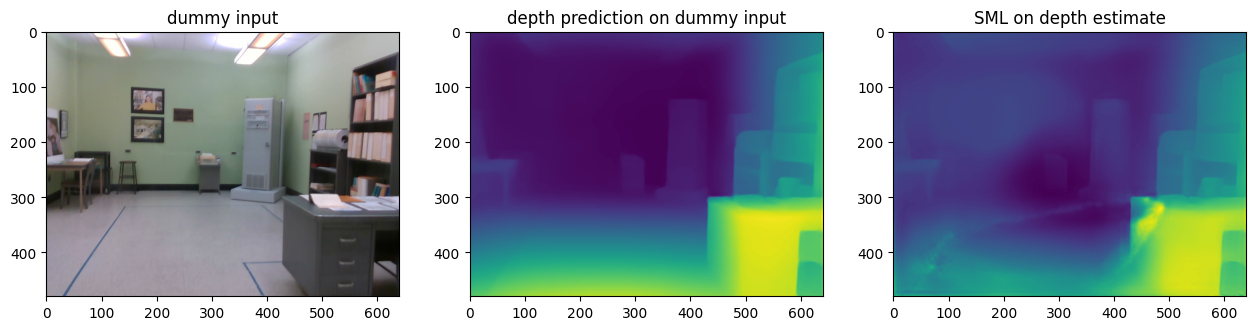

In [33]:
plt.figure()

img_dummy_in = mpimg.imread('data/image/dummy_img.png')
img_dummy_out = mpimg.imread(OUTPUT_DIR / 'dummy_input.png')
img_dummy_sml_out = mpimg.imread(OUTPUT_DIR / 'dummy_input_sml.png')

f, axes = plt.subplots(1, 3)
plt.subplots_adjust(right=2.0)

axes[0].imshow(img_dummy_in)
axes[1].imshow(img_dummy_out)
axes[2].imshow(img_dummy_sml_out)

axes[0].set_title('dummy input')
axes[1].set_title('depth prediction on dummy input')
axes[2].set_title('SML on depth estimate')

### Running inference on a test image
[back to top ⬆️](#Table-of-contents:)

Now role of both the dummy inputs i.e. the dummy image as well as its associated depth map is now over. Since we have access to the compiled models now, we can load the *one* image available to us for pure inferencing purposes and run all the above steps one by one till plotting of the depth map.

If you haven't noticed already the data directory of this tutorial has been arranged as follows. This allows us to comply to these [rules](https://github.com/pronoym99/openvino_notebooks/blob/main/CONTRIBUTING.md#file-structure).

 ```bash
    data
    ├── image                   
    │   ├── dummy_img.png       # RGB images
    │   └── <timestamp>.png
    └── sparse_depth            
        ├── dummy_img.png       # sparse metric depth maps
        └── <timestamp>.png     # as 16b PNG files
 ```
 
At the same time, the depth storage method [used in the VOID dataset](https://github.com/alexklwong/void-dataset/blob/master/src/data_utils.py) is assumed. 

If you are thinking of the file name format of the image for inference, here is the reasoning.
 
The dataset was collected using the Intel [RealSense D435i camera](https://realsense.intel.com/depth-camera), which was configured to produce synchronized accelerometer and gyroscope measurements at 400 Hz, along with synchronized VGA-size (640 x 480) RGB and depth streams at 30 Hz. The depth frames are acquired using active stereo and is aligned to the RGB frame using the sensor factory calibration. The frequency of sensor and depth stream input run at certain fixed frequencies and hence time stamping every frame captured is beneficial for maintaining structure as well as for debugging purposes later.

*The image for inference and it sparse depth map is taken from the compressed dataset present [here](https://drive.google.com/uc?id=1bbN46kR_hcH3GG8-jGRqAI433uddYrnc)*

In [34]:
# As before download the sample images for inference and take note of the image hashes if you 
# want to use them later
download_file('https://user-images.githubusercontent.com/22426058/254174393-fc6dcc5f-f677-4618-b2ef-22e8e5cb1ebe.png', filename='1552097950.2672.png', directory=Path(DATA_DIR / 'image'), silent=True)
download_file('https://user-images.githubusercontent.com/22426058/254174379-5d00b66b-57b4-4e96-91e9-36ef15ec5a0a.png', filename='1552097950.2672.png', directory=Path(DATA_DIR / 'sparse_depth'), silent=True)

# Load the image and its depth scale  
img_input = data_loader.load_input_image('data/image/1552097950.2672.png')
img_depth_input = data_loader.load_sparse_depth('data/sparse_depth/1552097950.2672.png')

# Transform the input image for the depth model
transformed_image = transform_image_for_depth(input_image=img_input, depth_model_transform=depth_model_transform)

# Run the depth model on the transformed input
depth_pred = run_depth_model(input_image_h=IMAGE_H, input_image_w=IMAGE_W,
                             transformed_image=transformed_image, compiled_depth_model=compiled_depth_model)


# Call the function on the sparse depth map
# with all default settings and store in appropriate variables
int_depth, int_scales = compute_global_scale_and_shift(input_sparse_depth=img_depth_input, validity_map=None, depth_pred=depth_pred)

# Transform the input image for the ScaleMapLearner model
transformed_image_scale = transform_image_for_depth_scale(input_image=img_input,
                                                          scale_map_learner_transform=scale_map_learner_transform,
                                                          int_depth=int_depth, int_scales=int_scales)

# Run the SML model using the set of inputs 
sml_pred = run_depth_scale_model(input_image_h=IMAGE_H, input_image_w=IMAGE_W,
                                 transformed_image_for_depth_scale=transformed_image_scale,
                                 compiled_scale_map_learner=compiled_scale_map_learner)

data\image\1552097950.2672.png:   0%|          | 0.00/371k [00:00<?, ?B/s]

data\sparse_depth\1552097950.2672.png:   0%|          | 0.00/3.07k [00:00<?, ?B/s]

### Store and visualize Inference results
[back to top ⬆️](#Table-of-contents:)


Text(0.5, 1.0, 'SML on depth estimate')

<Figure size 640x480 with 0 Axes>

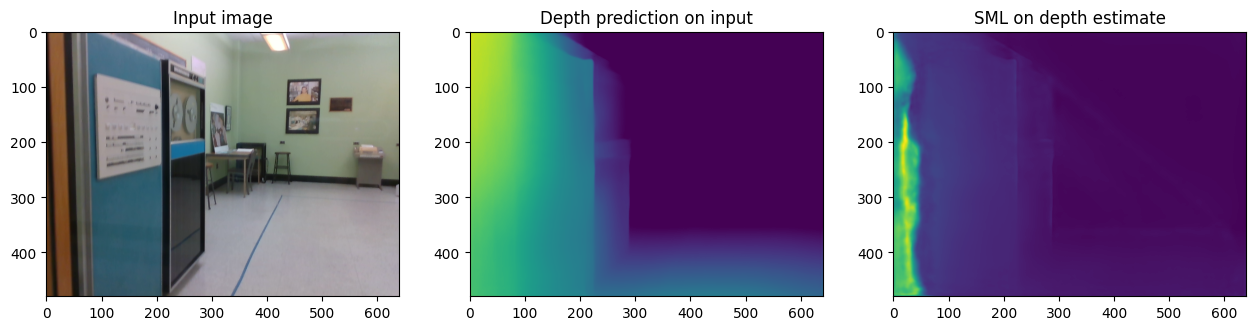

In [35]:
# Store the depth and SML predictions
utils.write_depth(path=str(OUTPUT_DIR / '1552097950.2672'), depth=int_depth, bits=2)
utils.write_depth(path=str(OUTPUT_DIR / '1552097950.2672_sml'), depth=sml_pred, bits=2)


# Display result
plt.figure()

img_in = mpimg.imread('data/image/1552097950.2672.png')
img_out = mpimg.imread(OUTPUT_DIR / '1552097950.2672.png')
img_sml_out = mpimg.imread(OUTPUT_DIR / '1552097950.2672_sml.png')

f, axes = plt.subplots(1, 3)
plt.subplots_adjust(right=2.0)

axes[0].imshow(img_in)
axes[1].imshow(img_out)
axes[2].imshow(img_sml_out)

axes[0].set_title('Input image')
axes[1].set_title('Depth prediction on input')
axes[2].set_title('SML on depth estimate')

#### Cleaning up the data directory
[back to top ⬆️](#Table-of-contents:)

We will _follow suit_ for the directory in which we downloaded images and depth maps from another repo. We shall move remove the unnecessary directories and files which were created during the download process.

In [36]:
# Remove the data directory and suppress errors(if any)
rmtree(path=str(DATA_DIR), ignore_errors=True)

### Concluding notes
[back to top ⬆️](#Table-of-contents:)

> 1. The code for this tutorial is adapted from the [VI-Depth repository](https://github.com/isl-org/VI-Depth).
> 2. Users may choose to download the original and raw datasets from the [VOID dataset](https://github.com/alexklwong/void-dataset/).
> 3. The [isl-org/VI-Depth](https://github.com/isl-org/VI-Depth) works on a slightly older version of released model assets from its [MiDaS sibling repository](https://github.com/isl-org/MiDaS). However, the new releases beginning from [v3.1](https://github.com/isl-org/MiDaS/releases/tag/v3_1) directly have OpenVINO™ `.xml` and `.bin` model files as their assets thereby rendering the **major pre-processing and model compilation step irrelevant**.